### Emma Klemets, 260775167   
All my work, code, output and written answers are in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simple_read_ligo import read_template, read_file
import json

In [2]:
#location of all my data and .json files
dataLocation = "./LOSC_Event_tutorial/"

#read json file for data names
with open(dataLocation+"BBH_events_v3.json") as f:
    jdata = json.load(f)

# the event data files (32s sampled at 4096 Hz, in hdf5 format, for both LIGO detectors).
# waveform templates (32s sampled at 4096 Hz, in hdf5 format, for both plus and cross polarizations).
#data from LIGO Hanford Observatory (H1) and LIGO Livingston Observatory (L1) 

#our 4 event names
events = ["GW150914", "GW151226", "LVT151012", "GW170104"]

"""
Easy function to get all the data out of the cooresponding data files
Uses simple_read_ligo functions, and ordering stored in BBH_events_v3.jdata
input: (int) event
    Index of event, matching the names in array 'events' (see above)
"""
def getData(event):

    #reading the data
    fnameH=jdata[events[event]]['fn_H1']
    fnameL=jdata[events[event]]['fn_L1']

    print('reading file ',fnameH)
    H1=read_file(dataLocation+fnameH) #strain,dt,utc
    L1=read_file(dataLocation+fnameL)
    '''
    strain: data taken
    dt: (1.0*duration)/len(strain)
    utc: UTCstart - start of event in Coordinated Universal Time
    '''

    #reading the template
    template_name=jdata[events[event]]['fn_template']
    template =read_template(dataLocation+template_name) #th,tl

    """
    th: Hanford template
    tl: Livingston template
    """
    
    return [H1, L1, template] #[[strain_H,dt_H,utc_H], [strain_L,dt_L,utc_L], [th,tl]]

reading file  H-H1_LOSC_4_V2-1126259446-32.hdf5



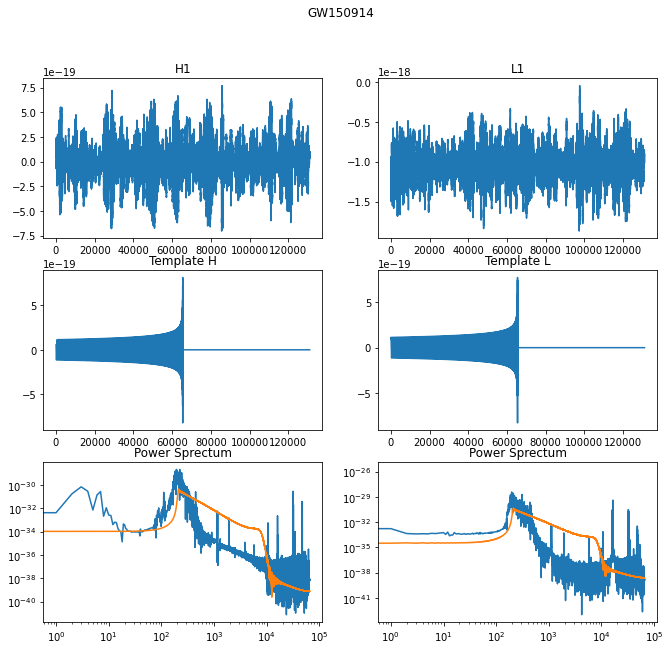

In [3]:
#get our data our for the GW150914 event
H1, L1, template = getData(0)
strain_H,dt_H,utc_H = H1
strain_L,dt_L,utc_L = L1
th,tl = template

#looking at the raw data
fig, ax = plt.subplots(3, 2, figsize=(11,10))
axs = ax.flatten()

fig.suptitle(events[0])

axs[0].set_title("H1")
axs[0].plot(strain_H)
axs[1].set_title("L1")
axs[1].plot(strain_L)

axs[2].set_title("Template H")
axs[2].plot(th)

axs[3].set_title("Template L")
axs[3].plot(tl)

axs[4].set_title("Power Sprectum")
axs[4].loglog(np.abs(np.fft.rfft(strain_H)**2))
axs[4].loglog(np.abs(np.fft.rfft(th)**2))

axs[5].set_title("Power Sprectum")
axs[5].loglog(np.abs(np.fft.rfft(strain_L)**2))
axs[5].loglog(np.abs(np.fft.rfft(tl)**2))

print()

#### a) 
Come up with a noise model for Livingston and Hanford separately. Describe in comments how you go about doing this. 
- something about how you smooth the power spectrum 
- how you deal with lines (if at all). 

Please also explain how you window the data (you may want to use a window that has an extended flat period near the center to avoid tapering the data/template where the signal is not small). 

I'm going to come up with my noise model, windowing etc only looking at the first event, and then simplyfy this process into a function to do the rest of the events quicker.

In [4]:
#windowing function - using Tukey one
def window(data, n=0, Type="cos", shift=False):
       
    if Type=="cos": #just a simple cosine window, but tapers alot of data
        x = np.linspace(-1, 1, len(data))*np.pi
        win=0.5 + 0.5*np.cos(x)
        
    elif Type=="flatcos": #cosine but in center is a boxcar to avoid making signal smaller - get weird spikes from this
        x = np.linspace(-1, 1, len(data))*np.pi
        win=0.5 + 0.5*np.cos(x)
        win[n:len(data)-n]=np.max(win)
        win=win/np.sum(n) #normalize

# Tukey window, also known as the cosine-tapered window - much nicer form
    elif Type=="Tukey":
        a=n
        N = int(len(data))
        L = N+1
        n = np.arange(N)
        win = 0.5*(1-np.cos(2*np.pi*n/(a*L)))
#         print(int(a*L/2), int(N/2))
        win[int(a*L/2):int(N/2)] = 1
        win[int(N/2):] = win[::-1][int(N/2):]
        
        if shift:
            win = win + np.mean(data)
            print(np.mean(data))
    
    windowedData = win*data
    return windowedData


In [5]:
#basic noise, gets PS from data
def noise(data, Type="square"):
    FT = np.fft.rfft(data)        
    N=np.abs(FT)**2
        
    return N #noiseData

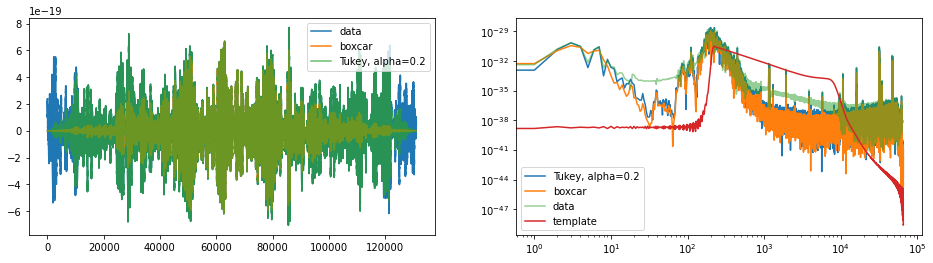

In [6]:
'''
first I want to window my data, tapering off the ends
I tried three functions for this, and the cosine-tapered window (Tukey) looked the best, 
not reducing the signal to much in the center, and still produced a similar power spectrum.
'''

fig, ax = plt.subplots(1, 2, figsize=(16,4))

alpha=0.2

strain_H_win = window(strain_H, n=alpha, Type="Tukey")

#need to window the signal as well
signal_win = window(th, n=alpha, Type="Tukey")

ax[0].plot(strain_H, label='data')
ax[0].plot(window(strain_H), label='boxcar')
ax[0].plot(window(strain_H, n=alpha, Type="Tukey"), alpha=0.7, label='Tukey, alpha={}'.format(alpha))

ax[1].loglog(np.abs(np.fft.rfft(strain_H_win)**2), label='Tukey, alpha={}'.format(alpha))
ax[1].loglog(np.abs(np.fft.rfft(window(strain_H))**2), label='boxcar')
ax[1].loglog(np.abs(np.fft.rfft(strain_H)**2), label='data', alpha=0.5)
ax[1].loglog(np.abs(np.fft.rfft(signal_win)**2), label='template')

ax[0].legend()
ax[1].legend()

plt.show()

In [7]:
#function for smoothing the data/noise - convolution with an another function
def smooth(data, num, Type="boxcar"):
    FT = np.fft.rfft(data)
    
    if Type=="boxcar":
        sm=np.zeros(len(data))
        #set center to 1
        sm[:num]=1
        sm[-num+1:]=1
        sm=sm/np.sum(sm) #normalize
        
        smFT = np.fft.rfft(sm)
        smoothedData = np.fft.irfft(smFT*FT, len(data)) # to make sure irfft is right length
        
    if Type=="gaussian":    
        sigma = num
        x_for_k = np.arange(-100, 100)#sets how many points to smooth over
        # Calculate gaussian
        k = np.exp(-(x_for_k) ** 2 / (2 * sigma ** 2))
        # Threshold to cut off gaussian at ends
        kernel_above_thresh = k > 0.0001
        finite_kernel = k[kernel_above_thresh]
        # normalize
        finite_kernel = finite_kernel / finite_kernel.sum()
        
        smoothedData = np.convolve(data, finite_kernel, mode='same')        
    
    return smoothedData


4.669678865530346e-33 4.660359348491808e-33


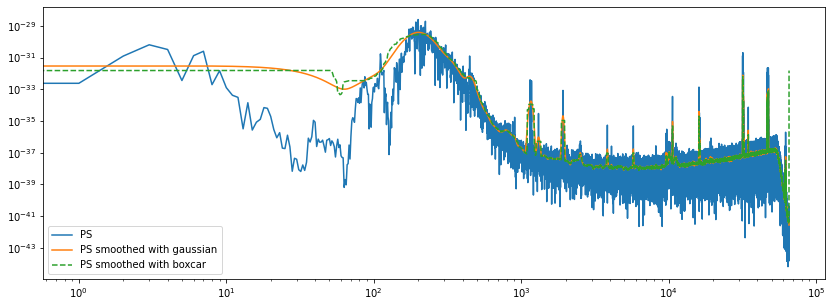

In [8]:
'''
For smoothing the noise (which is just the power spectrum of the windowed data), I decided to convolve with
a gaussian, as this averages over the data nicely, giving less sharp edges than the boxcar convolution.

'''

alpha=0.5
strain_H_win = window(strain_H, n=alpha, Type="Tukey")

H_noise = noise(strain_H_win)
signal_win = window(th, n=alpha, Type="Tukey")
# print(len(signal_win), len(H_noise))

#gaussian
H_noise_gau = smooth(H_noise, 20, 'gaussian')

print(np.mean(H_noise), np.mean(H_noise_gau))

plt.figure(figsize=(14,5))
plt.loglog(np.abs(np.fft.rfft(strain_H_win)**2), label="PS")
plt.loglog(H_noise_gau, label="PS smoothed with gaussian")

plt.loglog(smooth(H_noise, 50, 'boxcar'), ls="--", label="PS smoothed with boxcar")

#this makes it worse, so maybe not
# plt.loglog(np.maximum(H_noise, H_noise_gau), ls="--", label="max of PS smoothed with boxcar")

plt.legend()
plt.show()

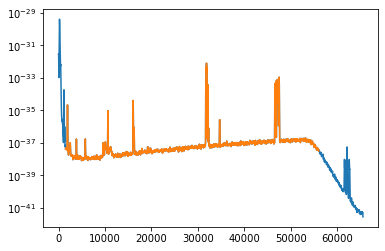

In [9]:
'''
Also with comparing to the LIGO noise seen in class, we only want the mid range frequences of this.
'''

# N = H_noise_gau[1500:56000] 
N_H = H_noise_gau.copy()

#but now my arrays are different lenghts, I guess I still need to add values for those I cut off - set to inf?
N_H[:1500] = np.inf
N_H[56000:] = np.inf

plt.semilogy(H_noise_gau, label="PS smoothed")
plt.semilogy(N_H, label="PS smoothed and cut")

### Now repeat for L data


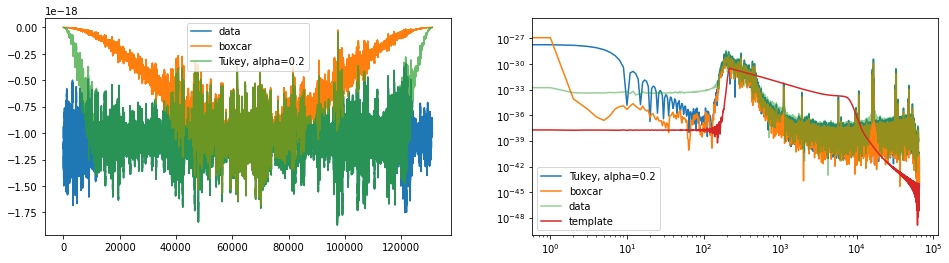

In [10]:
'''
first I want to window my data, tapering off the ends
I tried three functions for this, and the cosine-tapered window (Tukey) looked the best, 
not reducing the signal to much in the center, and still produced a similar power spectrum.

This data is now centered at 0, but around 1e-18, how to window this 
Maybe it's okay as I won't be looking at the edges anyways.

'''

fig, ax = plt.subplots(1, 2, figsize=(16,4))

alpha=0.2

strain_L_win = window(strain_L, n=alpha, Type="Tukey")

#need to window the signal as well
signal_win = window(tl, n=alpha, Type="Tukey")

ax[0].plot(strain_L, label='data')
ax[0].plot(window(strain_L), label='boxcar')
ax[0].plot(window(strain_L, n=alpha, Type="Tukey"), alpha=0.7, label='Tukey, alpha={}'.format(alpha))

ax[1].loglog(np.abs(np.fft.rfft(strain_L_win)**2), label='Tukey, alpha={}'.format(alpha))
ax[1].loglog(np.abs(np.fft.rfft(window(strain_L))**2), label='boxcar')
ax[1].loglog(np.abs(np.fft.rfft(strain_L)**2), label='data', alpha=0.5)


ax[1].loglog(np.abs(np.fft.rfft(signal_win)**2), label='template')

ax[0].legend()
ax[1].legend()

plt.show()

1.86118963933597e-31 9.850112720509651e-32


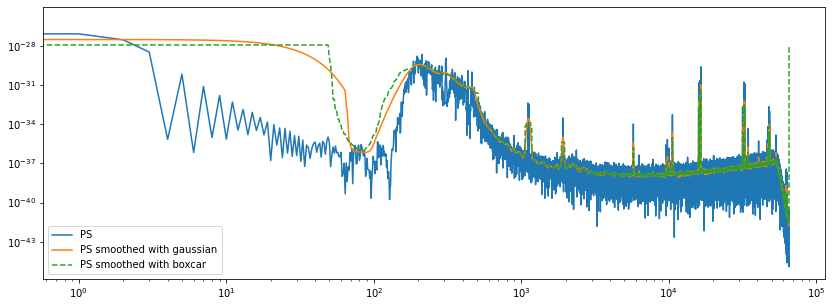

In [11]:
'''
For smoothing the noise (which is just the power spectrum of the windowed data), I decided to convolve with
a gaussian.

'''

alpha=0.5
strain_L_win = window(strain_L, n=alpha, Type="Tukey")

L_noise = noise(strain_L_win)
signal_win = window(tl, n=alpha, Type="Tukey")
# print(len(signal_win), len(H_noise))

#gaussian
L_noise_gau = smooth(L_noise, 15, 'gaussian')

print(np.mean(L_noise), np.mean(L_noise_gau))

plt.figure(figsize=(14,5))
plt.loglog(np.abs(np.fft.rfft(strain_L_win)**2), label="PS")
plt.loglog(L_noise_gau, label="PS smoothed with gaussian")

plt.loglog(smooth(L_noise, 50, 'boxcar'), ls="--", label="PS smoothed with boxcar")

#this makes it worse, so maybe not
# plt.loglog(np.maximum(L_noise, L_noise_gau), ls="--", label="max of PS smoothed with boxcar")

plt.legend()
plt.show()

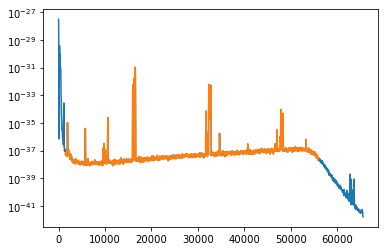

In [12]:
'''
Also with comparing to the LIGO noise seen in class, we only want the mid range frequences of this.
'''

# N = H_noise_gau[1500:56000] 
N_L = L_noise_gau.copy()
N_L[:1500] = np.inf
N_L[56000:] = np.inf

plt.semilogy(L_noise_gau, label="PS smoothed")
plt.semilogy(N_L, label="PS smoothed and cut")

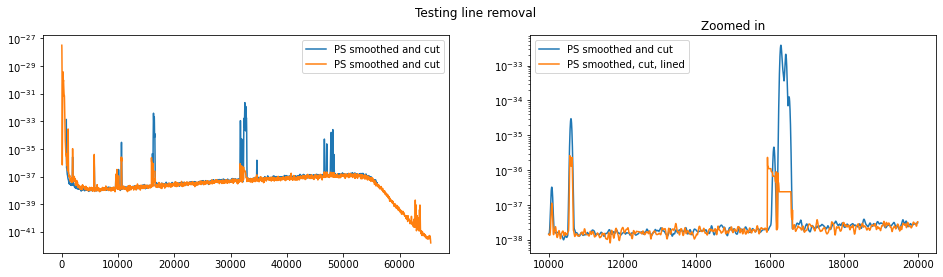

In [28]:
import numpy.ma as ma
""""
To remove lines if point is more than x times the ave of it's neightbors, set point to average
Using a masked array, so loop through once and mask out all values that should be removed, 
and then when calculating the average, this values are not used.
"""

#points to side to average over
sides = 8000

lines = np.zeros(len(L_noise_gau))

N_L_lines = L_noise_gau.copy()

for i in range(sides, len(L_noise_gau)-sides):
    ave = np.mean(L_noise_gau[i-sides:i+sides])
    
    if L_noise_gau[i] > ave*1.5:
        lines[i] = 1

#masking
masked = ma.masked_array(N_L_lines, mask=lines)
# print(lines)

#and repeat omitting any of the outlier points from the averages
for i in range(sides, len(L_noise_gau)-sides):
   
    ave2 = np.mean(masked[i-sides:i+sides])
    
    if L_noise_gau[i] > ave2*2:
        N_L_lines[i] = ave2

x = np.linspace(0, len(N_L), len(N_L))

fig, ax = plt.subplots(1, 2, figsize=(16,4))
fig.suptitle("Testing line removal")
ax[1].semilogy(x[10000:20000], N_L[10000:20000], label="PS smoothed and cut")
ax[1].semilogy(x[10000:20000], N_L_lines[10000:20000], label="PS smoothed, cut, lined")

ax[1].legend()
ax[1].set_title("Zoomed in")

ax[0].semilogy(N_L, label="PS smoothed and cut")
ax[0].semilogy(N_L_lines, label="PS smoothed and cut")
ax[0].legend()
plt.show()

In [14]:
"""
I decided not to remove the lines, as (at least for they way I was doing it), this made the 
noise to signal ratio worst, especially for the Livingston data.
"""
def removelines(noise_gau, sides = 4000):
    
    lines = np.zeros(len(noise_gau))

    N_L_lines = noise_gau.copy()

    for i in range(sides, len(noise_gau)-sides):
        ave = np.mean(noise_gau[i-sides:i+sides])

        if noise_gau[i] > ave*1.5:
            lines[i] = 1

    #masking
    masked = ma.masked_array(N_L_lines, mask=lines)

    #and repeat omitting any of the outlier points from the averages
    for i in range(sides, len(noise_gau)-sides):

        ave2 = np.mean(masked[i-sides:i+sides])

        if noise_gau[i] > ave2*1.5:
            N_L_lines[i] = ave2
        
    return N_L_lines

### Big function for getting my noise model for all

In [15]:
#now making a big function that will do all of this for the other data sets

def getNoiseModel(event, winAlpha=[0.5, 0.5], gauSig=[50,50], sides = 4000, graph=True):
    print("For event "+events[event])
    
    #get data
    H1, L1, template = getData(event)
    strain_H,dt_H,utc_H = H1
    strain_L,dt_L,utc_L = L1
    th,tl = template
    
    #windowing
    strain_H_win = window(strain_H, n=winAlpha[0], Type="Tukey")
    signal_win_H = window(th, n=winAlpha[0], Type="Tukey")
    
    #get PS for noise
    H_noise = noise(strain_H_win)

    #smooth noise by gaussian convolution
    H_noise_gau = smooth(H_noise, gauSig[0], 'gaussian')
    
    #try to remove lines - omited
#     N_H = removelines(H_noise_gau, sides)
    N_H = H_noise_gau.copy()
    
    cutH = [800, 56000]
    N_H[:cutH[0]] = np.inf
    N_H[cutH[1]:] = np.inf
    
    #repeat for L data
    #windowing
    strain_L_win = window(strain_L, n=winAlpha[1], Type="Tukey")
    signal_win_L = window(tl, n=winAlpha[1], Type="Tukey")
    
    #get PS for noise
    L_noise = noise(strain_L_win)

    #smooth noise by gaussian convolution
    L_noise_gau = smooth(L_noise, gauSig[1], 'gaussian')
    
#     N_L = removelines(L_noise_gau, sides)
    N_L = L_noise_gau.copy()
    
    cutL = [800, 56000]
    N_L[:cutL[0]] = np.inf
    N_L[cutL[1]:] = np.inf
    
    if graph:
        fig, ax = plt.subplots(2, 2, figsize=(16,6))
        axs = ax.flatten()

        axs[0].set_title("Hanford PS")
        axs[0].loglog(np.abs(np.fft.rfft(strain_H_win)**2), label="PS")
        axs[0].loglog(H_noise_gau, label="PS smoothed with gaussian")
        axs[0].loglog(smooth(H_noise, 50, 'boxcar'), ls="--", label="PS smoothed with boxcar")
        axs[0].loglog(np.abs(np.fft.rfft(signal_win_H)**2), label="Windowed template")

        axs[0].axvline(cutH[0], color='black', ls=":")
        axs[0].axvline(cutH[1], color='black', ls=":")

        axs[1].semilogy(H_noise_gau, label="PS smoothed")
        axs[1].semilogy(N_H, label="PS smoothed & cut")
    #     axs[1].semilogy(N_H, label="PS smoothed, de-lined & cut")

        #Livingston detector
        axs[2].set_title("Livingston PS")
        axs[2].loglog(np.abs(np.fft.rfft(strain_H_win)**2), label="PS")
        axs[2].loglog(L_noise_gau, label="PS smoothed with gaussian")
        axs[2].loglog(smooth(L_noise, 50, 'boxcar'), ls="--", label="PS smoothed with boxcar")
        axs[2].loglog(np.abs(np.fft.rfft(signal_win_L)**2), label="Windowed template")
        axs[2].axvline(cutL[0], color='black', ls=":")
        axs[2].axvline(cutL[1], color='black', ls=":")

        axs[3].semilogy(L_noise_gau, label="PS smoothed")
        axs[3].semilogy(N_L, label="PS smoothed & cut")
    #     axs[3].semilogy(N_L, label="PS smoothed, de-lined & cut")

        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
        axs[3].legend()
        plt.tight_layout()
        plt.show()
    
    return [strain_H_win, signal_win_H, N_H], [strain_L_win, signal_win_L, N_L]

For event GW150914
reading file  H-H1_LOSC_4_V2-1126259446-32.hdf5


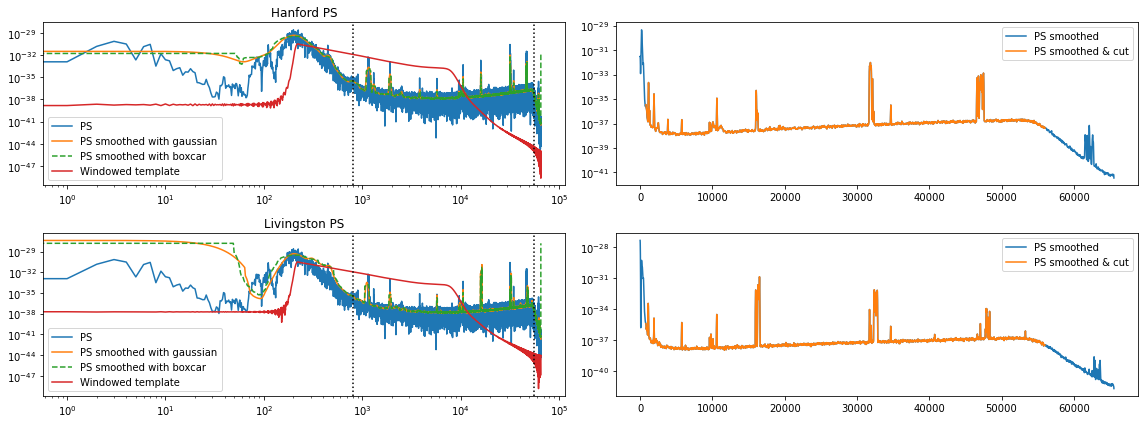

In [16]:
data0 = getNoiseModel(0, winAlpha=[0.2, 0.2], gauSig=[20,15])

For event GW151226
reading file  H-H1_LOSC_4_V2-1135136334-32.hdf5


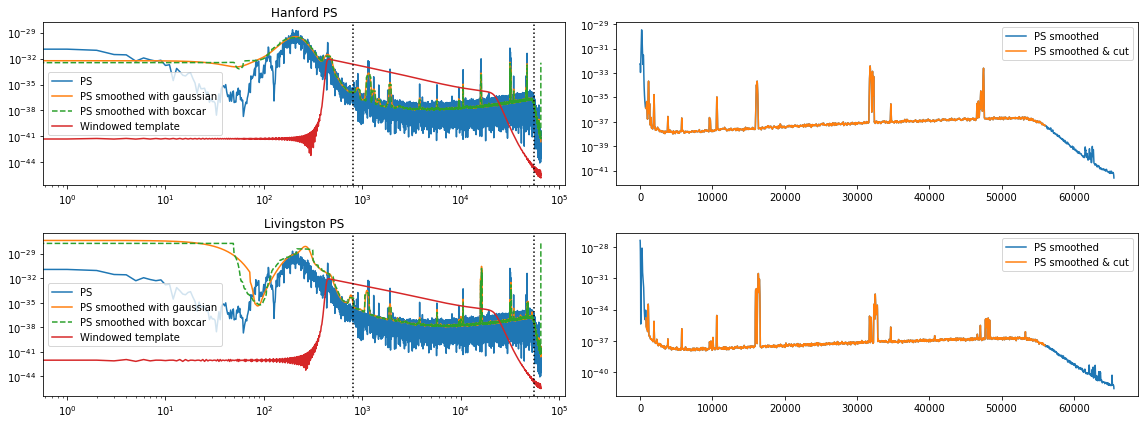

For event LVT151012
reading file  H-H1_LOSC_4_V2-1128678884-32.hdf5


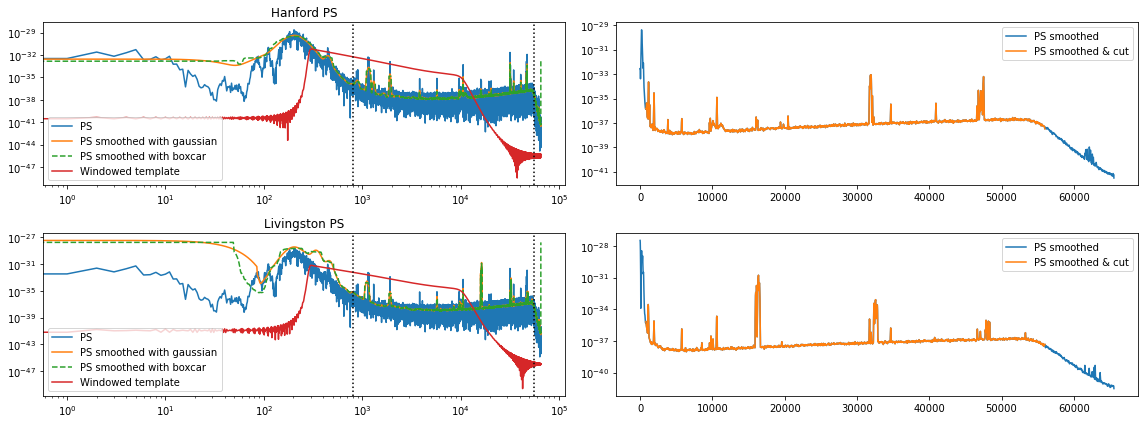

For event GW170104
reading file  H-H1_LOSC_4_V1-1167559920-32.hdf5


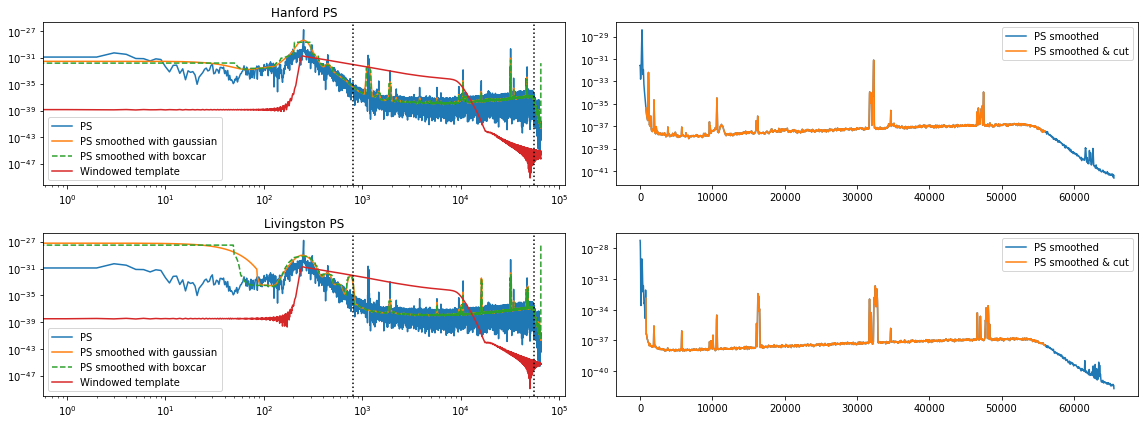

In [17]:
data1 = getNoiseModel(1, winAlpha=[0.2, 0.2], gauSig=[23,17])
data2 = getNoiseModel(2, winAlpha=[0.2, 0.2], gauSig=[20,20])
data3 = getNoiseModel(3, winAlpha=[0.2, 0.2], gauSig=[20,20])

dataAll = [data0, data1, data2, data3]

b) Use that noise model to search the four sets of events using a matched
filter. The mapping between data and templates can be found in the file BBH events v3.json, included in the zipfile. 

In [18]:
#match filter function
def matchFilter(data, template, N=0):
    if isinstance(N, int):#no noise matrix
        mf = np.fft.irfft(np.fft.rfft(data)*np.conj(np.fft.rfft(template)))
    else :#assume noise is is correct PS form
        mf = np.fft.irfft((np.fft.rfft(data)/N)*np.conj(np.fft.rfft(template)))
    return mf

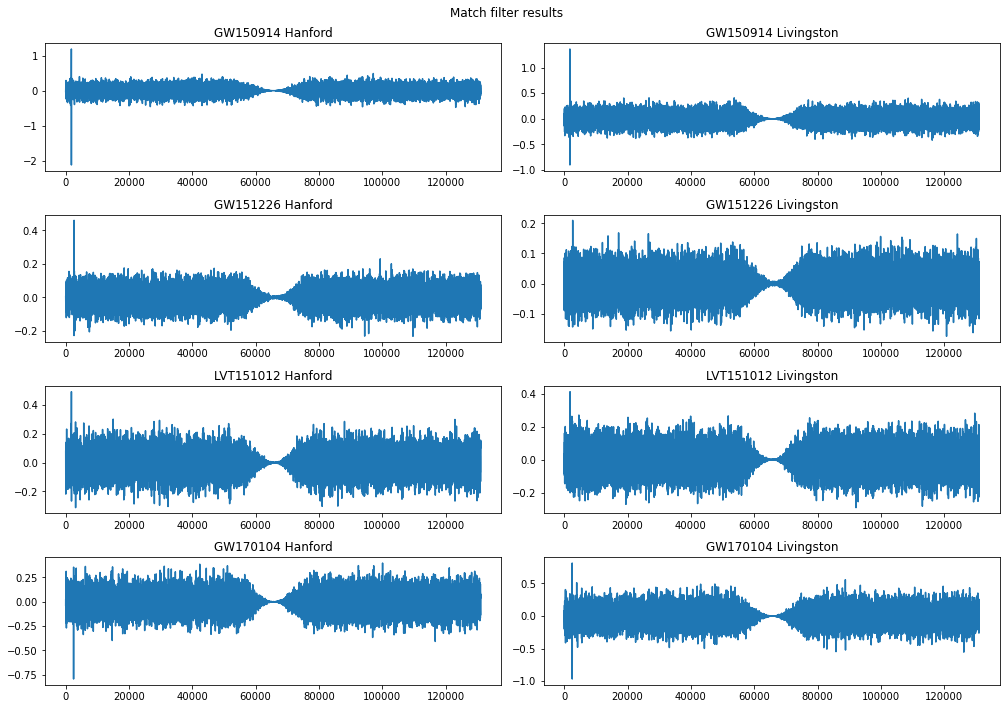

In [19]:
"""
whitening - use N^-1/2 A and N^-1/2 d for the template and strain for running the matched filter.
this will help as then the noise is uncorrelated and not create peaks on the match filter, 
leaving (hopefully) only the true signal to match
"""

data_white = []
MFs = []

fig, ax = plt.subplots(4, 2, figsize=(14,10))
axs = ax.flatten()

fig.suptitle("Match filter results")
i=0
for data in dataAll:
    
    [strain_H_win, signal_win_H, N_H], [strain_L_win, signal_win_L, N_L] = data
    
    strain_H_whit = np.fft.irfft((N_H**-0.5)*np.fft.rfft(strain_H_win), len(strain_H_win))
    signal_H_whit = np.fft.irfft((N_H**-0.5)*np.fft.rfft(signal_win_H), len(signal_win_H))
    
    strain_L_whit = np.fft.irfft((N_L**-0.5)*np.fft.rfft(strain_L_win), len(strain_L_win))
    signal_L_whit = np.fft.irfft((N_L**-0.5)*np.fft.rfft(signal_win_L), len(signal_win_L))

    #running the match filter with the whitened data
    mf_H = matchFilter(strain_H_whit, signal_H_whit)
    mf_L = matchFilter(strain_L_whit, signal_L_whit)
    
    axs[i].set_title("{} Hanford".format(events[int(i/2)]))
    axs[i].plot(mf_H)
    
    axs[i+1].set_title("{} Livingston".format(events[int(i/2)]))
    axs[i+1].plot(mf_L)
    i=i+2
    
    MFs.append([mf_H, mf_L])
    data_white.append([[strain_H_whit, signal_H_whit],[strain_L_whit, signal_L_whit]])

plt.tight_layout()
plt.show()

#other events don't have a great ratio

### c) 
Estimate a noise for each event, and from the output of the matched
filter, give a signal-to-noise ratio for each event, both from the individual detectors, and from the combined Livingston + Hanford events. 

In [20]:
#get noise and signal to noise ratio for each event
sigToNoise = []

noiseStart = 10000
noiseEnd = 55000

for i, data in enumerate(dataAll):
    print(events[i])

    #take noise as the std in the match fliter - use areas where noise is correctly large 
    # -> not the small bit from the windowing
    noiseEst_H = np.std(MFs[i][0][noiseStart:noiseEnd])
    noiseEst_L = np.std(MFs[i][1][noiseStart:noiseEnd])

    sigToNoise_H = np.max(np.abs(MFs[i][0]))/noiseEst_H
    sigToNoise_L = np.max(np.abs(MFs[i][1]))/noiseEst_L
       
    #   chiS = STN^2
    #total signal to noise is then: sqrt(STN^2 + STN^2) 
    sigToNoise_tot = np.sqrt(sigToNoise_H**2 + sigToNoise_L**2)

    #print out results
    print("Hanford noise estimate: {:.5}, signal to noise ratio: {:.5}".format(noiseEst_H, sigToNoise_H))
    print("Livingston noise estimate: {:.5}, signal to noise ratio: {:.5}".format(noiseEst_L, sigToNoise_L))
    print("Combined signal to noise ratio: {:.5}\n".format(sigToNoise_tot))

    #and save them
    sigToNoise.append([sigToNoise_H, sigToNoise_L, sigToNoise_tot])

#for both detectors, average between two?

GW150914
Hanford noise estimate: 0.11959, signal to noise ratio: 17.71
Livingston noise estimate: 0.10951, signal to noise ratio: 12.442
Combined signal to noise ratio: 21.644

GW151226
Hanford noise estimate: 0.050893, signal to noise ratio: 9.0403
Livingston noise estimate: 0.040289, signal to noise ratio: 5.212
Combined signal to noise ratio: 10.435

LVT151012
Hanford noise estimate: 0.076932, signal to noise ratio: 6.4052
Livingston noise estimate: 0.073314, signal to noise ratio: 5.6352
Combined signal to noise ratio: 8.5312

GW170104
Hanford noise estimate: 0.096374, signal to noise ratio: 8.2356
Livingston noise estimate: 0.13238, signal to noise ratio: 7.2935
Combined signal to noise ratio: 11.001



### d) 
Compare the signal-to-noise you get from the scatter in the matched
filter to the analytic signal-to-noise you expect from your noise model. How close are they? If they disagree, can you explain why? 

$m / \sigma_m= \frac{data}{noise}$

$ \sigma_m=\sqrt{(A^TN^{-1}A)^{-1}}$

With our pre-whiten template, N is diagonal and $\tilde{A} = N^{-1/2}A$, using this $\tilde{A}^T = (N^{-1/2}A)^T = A^T (N^{-1/2})^T$, 

$
A=N^{-1/2}\tilde{A} ~~\&~~ A^T=\tilde{A}^T (N^{-1/2})^T \\
A^TN^{-1}A = \tilde{A}^T (N^{-1/2})^T N^{-1} N^{-1/2}\tilde{A} \\
= \tilde{A}^T (N^{-1/2})^T N^{-1/2} N^{-1/2} N^{-1/2}\tilde{A}  ~~\text{N is symmetric}\\
= \tilde{A}^T (N^{-1/2})^T N^{-1/2} (N^{-1/2})^T N^{-1/2}\tilde{A}\\
= \tilde{A}^T \tilde{A} ~~\text{But our A's are 1D, so this is simply}\\
= \tilde{A}^2
$

$ \sigma_m=\sqrt{(A)^{-2}}$



m is simply our matched filter, and the noise needs to be the noise on the model -> so on the template. Using whitened template as here the noise should be diagonal and therefore taking it as the std.

In [21]:
for i, data in enumerate(dataAll):
    [strain_H_win, signal_win_H, N_H], [strain_L_win, signal_win_L, N_L] = data

    # data_white
    signal_win_H_white = data_white[i][0][1]

    sigma = np.sqrt(np.mean(signal_win_H_white**2))
#     which is really the same as np.std(signal_win_H_white)

    #mf / noise on model
    SNR_H = MFs[i][0]/sigma
    SNR_L= MFs[i][1]/sigma
    
    sigToNoise_tot = np.sqrt((np.abs(SNR_H).max())**2 + (np.abs(SNR_L).max())**2)

#     plt.plot(SNR_H)
    print(events[i])
    print("sigma_m: {:.5}, SNR H: {:.5}, SNR L: {:.5}, combined: {:.5}\n".format(sigma, np.abs(SNR_H).max(), np.abs(SNR_L).max(), sigToNoise_tot))
plt.show()

GW150914
sigma_m: 0.11496, SNR H: 18.425, SNR L: 11.852, combined: 21.907

GW151226
sigma_m: 0.049753, SNR H: 9.2474, SNR L: 4.2206, combined: 10.165

LVT151012
sigma_m: 0.07377, SNR H: 6.6798, SNR L: 5.6003, combined: 8.7169

GW170104
sigma_m: 0.094392, SNR H: 8.4086, SNR L: 10.229, combined: 13.241



Most of the values are close, but they do not completely match (particularly event GW170104 is off). However, between the two methods, one isn't consistently higher than the other which implies that the different does not come from an accidently bias somewhere in my modeling. I suspect that the noise model may cause this, taking it simply as the STD, and also the effect of the window function may still be changing this mode, even though I tried to pick a range that to the eye looks uneffected.

### e) 
From the template and noise model, find the frequency from each event
where half the weight comes from above that frequency and half below. 

In [22]:
#getting frequency array
# dt in sec  -> want Hz

# print(dt_H,dt_L) #they are all the same
time = np.arange(0, len(strain_H))*dt_H
# print(time)

samp_rate = 1.0/dt_H
print(samp_rate) #matches fs in json file

freqs = np.arange(0, len(strain_H))*(samp_rate/len(strain_H))
# print(freqs)
freqs = freqs[:int(len(strain_H)/2+1)] #only take the first half of the values to match my rfft lengths


4096.0


half points: 110.75 Hz, 119.3125 Hz
half points: 87.3125 Hz, 109.59375 Hz
half points: 87.78125 Hz, 99.34375 Hz
half points: 102.59375 Hz, 77.0625 Hz


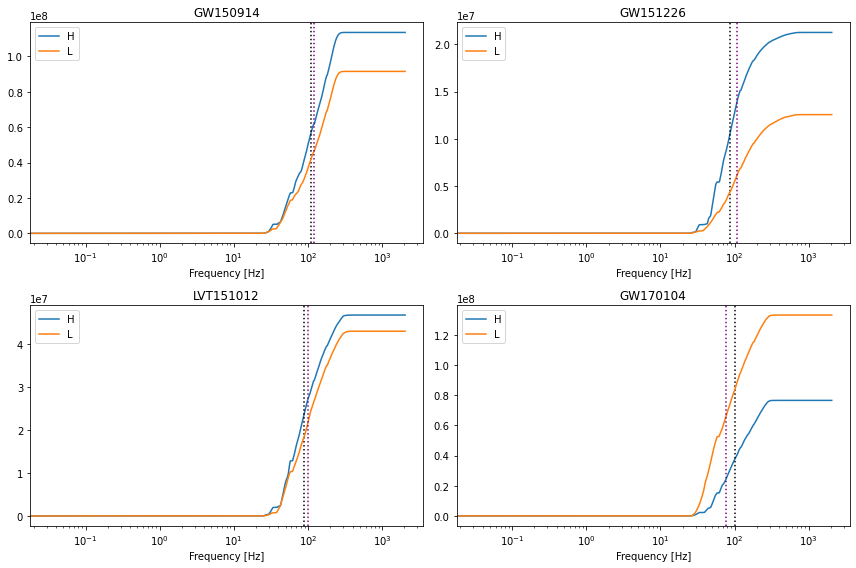

In [23]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

fig, ax = plt.subplots(2, 2, figsize=(12,8))
axs = ax.flatten()

#doing a cumulative sum to find center point of weighting
for j, data in enumerate(data_white):
    [[strain_H_whit, signal_H_whit],[strain_L_whit, signal_L_whit]] = data

    signal_H_white_ps = np.abs(np.fft.rfft(signal_H_whit)**2)

    TotalWeight = np.zeros(len(signal_H_white_ps))
    TotalWeight[0] = signal_H_white_ps[0]
    
    #get cumulative weight at each point
    for i in range(1, len(signal_H_white_ps)):
        TotalWeight[i] = signal_H_white_ps[i] + TotalWeight[i-1]

    half = TotalWeight[-1]/2
    
    halfPointVal_H, halfPoint_H = find_nearest(TotalWeight, half)
    
    axs[j].set_title(events[j])
    axs[j].semilogx(freqs, TotalWeight, label="H")
    axs[j].axvline(freqs[halfPoint_H], ls=":", color='black')

    #repeat for L
    signal_L_white_ps = np.abs(np.fft.rfft(signal_L_whit)**2)

    TotalWeight = np.zeros(len(signal_L_white_ps))
    TotalWeight[0] = signal_L_white_ps[0]
    
    #get cumulative weight at each point
    for i in range(1, len(signal_L_white_ps)):
        TotalWeight[i] = signal_L_white_ps[i] + TotalWeight[i-1]

    half = TotalWeight[-1]/2
    
    halfPointVal, halfPoint = find_nearest(TotalWeight, half)
    
    axs[j].semilogx(freqs, TotalWeight, label="L")
    axs[j].axvline(freqs[halfPoint], ls=":", color='purple')
    axs[j].set_xlabel("Frequency [Hz]")
    
    axs[j].legend()
    print("half points: {} Hz, {} Hz".format(freqs[halfPoint_H], freqs[halfPoint]))

plt.tight_layout()
plt.show()   

### f) 
How well can you localize the time of arrival (the horizontal shift of your matched filter). The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainy you might expect given that the detectors area a few thousand km apart?

In [24]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

from scipy.optimize import curve_fit

[0.96235627 0.43229789 0.00240053]


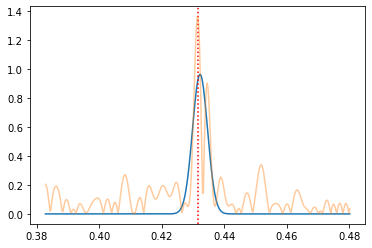

[0.13812824 0.64659915 0.00399026]


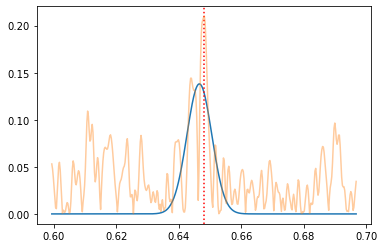

[0.11618532 0.43901114 0.02787965]


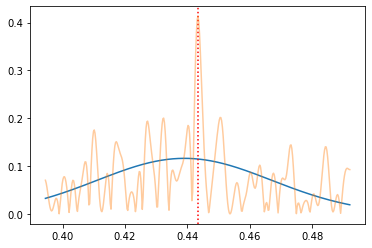

[0.679262   0.61118774 0.00454323]


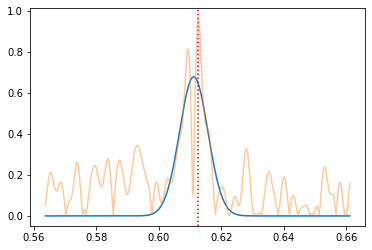

In [25]:
"""
trying to use Gaussian to get error on peak fit, it works ok for most of them, except one. 
And still isn't a great error to use as it's not fitting all the way to the peak as it's catching 
the next highest points as well.
"""

maxes = []

for i, data in enumerate(data_white):

    #get max point
    max2_H = np.argmax(np.abs(MFs[i][0]))
    max2_L = np.argmax(np.abs(MFs[i][1]))
    maxes.append([max2_H, max2_L])

# maxes
i=0
# a, x0, sigma

fitrange = [1000, 3500]

#third event isn't fitting for L
for i, data in enumerate(data_white):
    
    fitrange = [maxes[i][1]-200, maxes[i][1]+200]

    popt, pcov = curve_fit(gauss_function, time[fitrange[0]:fitrange[1]], np.abs(MFs[i][1])[fitrange[0]:fitrange[1]], p0 = [1.0, time[maxes[i][1]], 0.001])

    plt.plot(time[fitrange[0]:fitrange[1]], gauss_function(time[fitrange[0]:fitrange[1]], *popt), label='fit')
    plt.axvline(time[maxes[i][1]], ls=":", color='red')

    plt.plot(time[fitrange[0]:fitrange[1]], np.abs(MFs[i][1])[fitrange[0]:fitrange[1]], alpha=0.4)

    print(popt)
    plt.show()

GW150914
time difference from max points: 8.789e-03, from fit 6.897e-03
1 sigma spread: H: 2.400e-03, L: 3.187e-03

GW151226
time difference from max points: 4.883e-04, from fit 1.093e-03
1 sigma spread: H: 3.977e-03, L: 1.335e-03

LVT151012
Note this fit really doesn't converge
time difference from max points: 1.953e-03, from fit 5.796e+03
1 sigma spread: H: 2.120e+03, L: 1.204e-03

GW170104
time difference from max points: 4.639e-03, from fit 2.443e-03
1 sigma spread: H: 4.542e-03, L: 2.762e-03



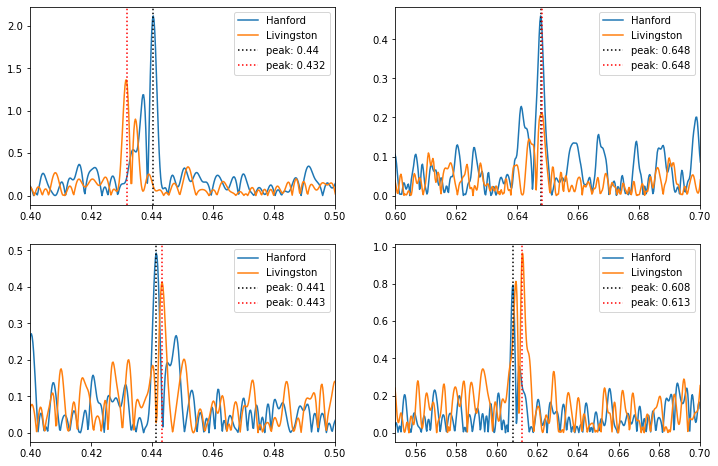

In [26]:
# need time on axis

i=0
fig, ax = plt.subplots(2, 2, figsize=(12,8))
axs = ax.flatten()

#zoom in and look
xlims = [[0.4, 0.5], [0.6, 0.7], [0.4, 0.5], [0.55, 0.7]]
maxes = []

for i, data in enumerate(data_white):

    #get max point
    max2_H = np.argmax(np.abs(MFs[i][0]))
    max2_L = np.argmax(np.abs(MFs[i][1]))
    maxes.append([max2_H, max2_L])
    
    #also looking at fitting a gaussian for error - popt = [a, x0, sigma]
    popt_H, pcov = curve_fit(gauss_function, time, np.abs(MFs[i][0]), p0 = [1, time[max2_H], 0.002])
    popt_L, pcov = curve_fit(gauss_function, time, np.abs(MFs[i][1]), p0 = [1, time[max2_L], 0.002])
    
    print(events[i])
    
    if i==2:
        print("Note this fit really doesn't converge")
    
    print("time difference from max points: {:.3e}, from fit {:.3e}".format(np.abs(time[max2_H]-time[max2_L]), np.abs(popt_L[1]-popt_H[1])))
#     print("diff with fit: {:.3e}".format())
    print("1 sigma spread: H: {:.3e}, L: {:.3e}\n".format(popt_L[2], popt_H[2]))
    
#     A = np.abs(MFs[i][0])
#     sig_H = sum(A[A> np.max(A)*0.65])
#     print(sig_H)
    
#     print("diff with ave: {:.3e}".format(np.abs( np.abs(time[max_H]-time[min_H])/2.0 - np.abs(time[max_L]-time[min_L])/2.0 )))
#     print()

    axs[i].plot(time, np.abs(MFs[i][0]), label="Hanford")
    axs[i].plot(time, np.abs(MFs[i][1]), label="Livingston")
    axs[i].axvline(time[max2_H], ls=":", color='black', label="peak: {:.3}".format(time[max2_H]))
    axs[i].axvline(time[max2_L], ls=":", color='red', label="peak: {:.3}".format(time[max2_L]))

    # plt.xlim(1000, 2500)
    axs[i].set_xlim(xlims[i][0], xlims[i][1])
    axs[i].legend()

plt.show()

In [27]:
#analytically

distance = 3e6 #detectors are 3000km apart
c=3e8 #gravitational waves travel at the speed of light

timeDiff = distance/c
print("time delay of ~", timeDiff, "s")

#this is not what it wants -> angular positional uncertainty

time delay of ~ 0.01 s


*The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainy you might expect given that the detectors area a few thousand km apart?*

